# Prédiction des Maladies Cardiaques
Ce notebook propose un pipeline complet pour la détection des maladies cardiaques.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, learning_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, roc_curve
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier
import xgboost as xgb

plt.style.use('default')
sns.set_palette('Set2')


In [3]:
df = pd.read_csv('../Heart/heart.csv')
print(f'📊 Dataset chargé : {df.shape[0]} lignes, {df.shape[1]} colonnes')
df.head()

📊 Dataset chargé : 303 lignes, 14 colonnes


📊 Dataset chargé : 303 lignes, 14 colonnes


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [4]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


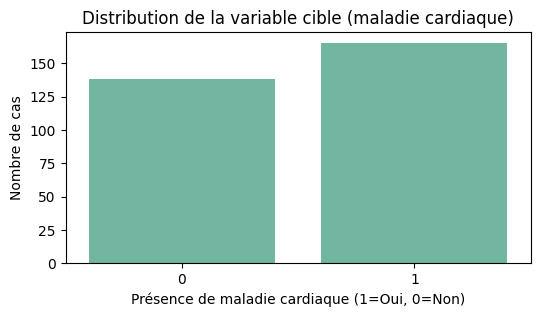

target
1    0.544554
0    0.455446
Name: proportion, dtype: float64


In [5]:
plt.figure(figsize=(6,3))
sns.countplot(x='target', data=df)
plt.title('Distribution de la variable cible (maladie cardiaque)')
plt.xlabel('Présence de maladie cardiaque (1=Oui, 0=Non)')
plt.ylabel('Nombre de cas')
plt.show()

print(df['target'].value_counts(normalize=True).rename('proportion'))

In [7]:

X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print(f'Train: {X_train.shape}, Test: {X_test.shape}')

Train: (242, 13), Test: (61, 13)


In [8]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
xgb_estimator = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
rfe = RFE(xgb_estimator, n_features_to_select=8)
rfe.fit(X_train_scaled, y_train)

selected_features = X.columns[rfe.support_]
print('Features sélectionnées :', list(selected_features))

X_train_sel = X_train_scaled[:, rfe.support_]
X_test_sel = X_test_scaled[:, rfe.support_]

Features sélectionnées : ['age', 'sex', 'cp', 'exang', 'oldpeak', 'slope', 'ca', 'thal']


In [10]:

models = {
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'MLP': MLPClassifier(hidden_layer_sizes=(32,16), max_iter=1000, random_state=42),
    'Naive Bayes': GaussianNB(),
    'KNN': KNeighborsClassifier(n_neighbors=7),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=42)
}


In [11]:

from sklearn.model_selection import cross_val_score
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {}

for name, model in models.items():
    print(f'📊 {name}...')
    scores = cross_val_score(model, X_train_sel, y_train, cv=cv, scoring='roc_auc')
    model.fit(X_train_sel, y_train)
    y_pred = model.predict(X_test_sel)
    y_proba = model.predict_proba(X_test_sel)[:,1] if hasattr(model, 'predict_proba') else None
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None
    results[name] = {
        'model': model,
        'cv_auc_mean': scores.mean(),
        'cv_auc_std': scores.std(),
        'test_auc': auc,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred)
    }
    print(f'   CV AUC: {scores.mean():.3f} (±{scores.std():.3f}) | Test AUC: {auc:.3f}')

📊 XGBoost...
   CV AUC: 0.871 (±0.054) | Test AUC: 0.926
📊 MLP...
   CV AUC: 0.871 (±0.054) | Test AUC: 0.926
📊 MLP...
   CV AUC: 0.887 (±0.063) | Test AUC: 0.908
📊 Naive Bayes...
   CV AUC: 0.882 (±0.073) | Test AUC: 0.890
📊 KNN...
   CV AUC: 0.859 (±0.086) | Test AUC: 0.866
📊 AdaBoost...
   CV AUC: 0.887 (±0.063) | Test AUC: 0.908
📊 Naive Bayes...
   CV AUC: 0.882 (±0.073) | Test AUC: 0.890
📊 KNN...
   CV AUC: 0.859 (±0.086) | Test AUC: 0.866
📊 AdaBoost...
   CV AUC: 0.877 (±0.037) | Test AUC: 0.937
   CV AUC: 0.877 (±0.037) | Test AUC: 0.937


In [12]:
voting = VotingClassifier(
    estimators=[
        ('xgb', models['XGBoost']),
        ('mlp', models['MLP']),
        ('knn', models['KNN'])
    ],
    voting='soft'
)
voting.fit(X_train_sel, y_train)
y_pred_voting = voting.predict(X_test_sel)
y_proba_voting = voting.predict_proba(X_test_sel)[:,1]
voting_auc = roc_auc_score(y_test, y_proba_voting)

results['Voting'] = {
    'model': voting,
    'cv_auc_mean': np.nan,
    'cv_auc_std': np.nan,
    'test_auc': voting_auc,
    'accuracy': accuracy_score(y_test, y_pred_voting),
    'precision': precision_score(y_test, y_pred_voting),
    'recall': recall_score(y_test, y_pred_voting),
    'f1': f1_score(y_test, y_pred_voting)
}
print(f'📊 Voting Classifier | Test AUC: {voting_auc:.3f}')

📊 Voting Classifier | Test AUC: 0.926


In [13]:
# Résumé des performances

results_df = pd.DataFrame([{
    'Modèle': k,
    'AUC-ROC': v['test_auc'],
    'Accuracy': v['accuracy'],
    'Precision': v['precision'],
    'Recall': v['recall'],
    'F1': v['f1'],
    'CV AUC (mean)': v['cv_auc_mean'],
    'CV AUC (std)': v['cv_auc_std']
} for k,v in results.items()])

results_df = results_df.sort_values('AUC-ROC', ascending=False)
print(results_df.round(3))

        Modèle  AUC-ROC  Accuracy  Precision  Recall     F1  CV AUC (mean)  \
4     AdaBoost    0.937     0.869      0.821   0.970  0.889          0.877   
0      XGBoost    0.926     0.852      0.786   1.000  0.880          0.871   
5       Voting    0.926     0.869      0.805   1.000  0.892            NaN   
1          MLP    0.908     0.836      0.780   0.970  0.865          0.887   
2  Naive Bayes    0.890     0.836      0.780   0.970  0.865          0.882   
3          KNN    0.866     0.803      0.839   0.788  0.812          0.859   

   CV AUC (std)  
4         0.037  
0         0.054  
5           NaN  
1         0.063  
2         0.073  
3         0.086  


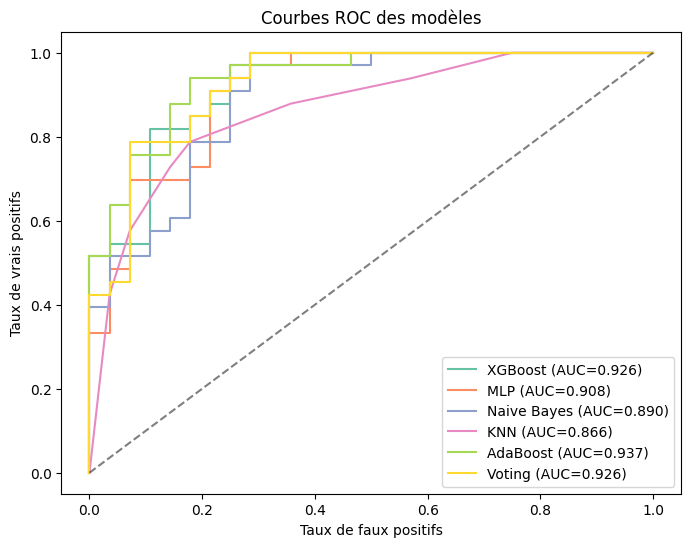

In [14]:

plt.figure(figsize=(8,6))
for name, res in results.items():
    model = res['model']
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test_sel)[:,1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.plot(fpr, tpr, label=f'{name} (AUC={res["test_auc"]:.3f})')
plt.plot([0,1],[0,1],'k--',alpha=0.5)
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbes ROC des modèles')
plt.legend()
plt.show()

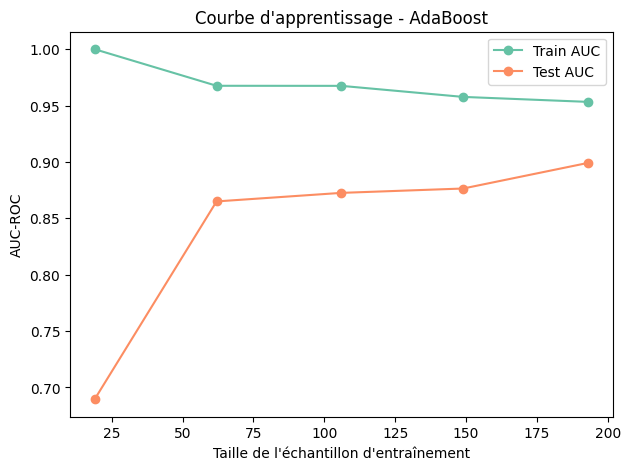

In [16]:

best_name = results_df.iloc[0]['Modèle']
best_model = results[best_name]['model']
train_sizes, train_scores, test_scores = learning_curve(best_model, X_train_sel, y_train, cv=5, scoring='roc_auc', n_jobs=-1, train_sizes=np.linspace(0.1,1.0,5))
train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)
plt.figure(figsize=(7,5))
plt.plot(train_sizes, train_mean, 'o-', label='Train AUC')
plt.plot(train_sizes, test_mean, 'o-', label='Test AUC')
plt.xlabel("Taille de l'échantillon d'entraînement")
plt.ylabel('AUC-ROC')
plt.title(f'Courbe d\'apprentissage - {best_name}')
plt.legend()
plt.show()

In [18]:

if best_name == 'XGBoost':
    param_dist = {
        'n_estimators': [50, 100, 200],
        'max_depth': [2, 3, 4, 5],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'subsample': [0.7, 0.8, 1.0]
    }
    search = RandomizedSearchCV(best_model, param_distributions=param_dist, n_iter=10, cv=3, scoring='roc_auc', random_state=42, n_jobs=-1)
    search.fit(X_train_sel, y_train)
    print('Meilleurs hyperparamètres:', search.best_params_)
    print('Meilleur score AUC:', search.best_score_)

              precision    recall  f1-score   support

           0       0.95      0.75      0.84        28
           1       0.82      0.97      0.89        33

    accuracy                           0.87        61
   macro avg       0.89      0.86      0.86        61
weighted avg       0.88      0.87      0.87        61



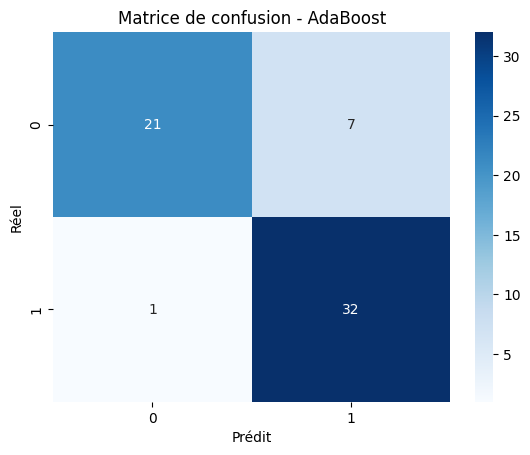

In [19]:
y_pred_best = best_model.predict(X_test_sel)
print(classification_report(y_test, y_pred_best))
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Matrice de confusion - {best_name}')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.show()

In [20]:
import joblib
import os
os.makedirs('models', exist_ok=True)
joblib.dump(best_model, 'models/best_heart_model.pkl')
joblib.dump(scaler, 'models/heart_scaler.pkl')
joblib.dump(list(selected_features), 'models/heart_features.pkl')
print('Modèle, scaler et features sauvegardés !')

Modèle, scaler et features sauvegardés !


In [26]:
import pandas as pd
import numpy as np
import joblib

def predict_heart_disease(patient_data, model_path='models/best_heart_model.pkl', scaler_path='models/heart_scaler.pkl', features_path='models/heart_features.pkl'):
    model = joblib.load(model_path)
    scaler = joblib.load(scaler_path)
    features = joblib.load(features_path)

    all_columns = [
        'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
        'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal'
    ]

    if isinstance(patient_data, dict):
        X_new = pd.DataFrame([patient_data])
    else:
        X_new = patient_data.copy()

    for col in all_columns:
        if col not in X_new.columns:
            X_new[col] = 0
    X_new = X_new[all_columns]

    X_new_scaled = scaler.transform(X_new)

    features_idx = [all_columns.index(f) for f in features]
    X_new_sel = X_new_scaled[:, features_idx]

    proba = model.predict_proba(X_new_sel)[0,1]
    pred = model.predict(X_new_sel)[0]
    risk_level = 'Élevé' if proba > 0.7 else 'Modéré' if proba > 0.3 else 'Faible'
    return {
        'prediction': int(pred),
        'probabilité_maladie': float(proba),
        'niveau_risque': risk_level
    }
